### First architecture: 
As a first architecture, we reshape the data in order to only learn the classes of each image. The comparison of labels is done as a post-processing step. 

In [1]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

import dlc_practical_prologue as prologue
%matplotlib inline

### Load data 

In [2]:
N = 1000
train_input, train_target_final, train_classes, test_input, test_target_final,test_classes = prologue.generate_pair_sets(N)

In [ ]:
# Show images
img1 = train_input[5][0]
plt.imshow(img1)
plt.show()
img2 = train_input[5][1]
plt.imshow(img2)
plt.show()

### Define one-hot classes

In [ ]:
train_binary_classes = torch.full((2*N,10), 0)
test_binary_classes = torch.full((2*N, 10), 0)

In [ ]:
test_classes

In [ ]:
train_binary_classes.scatter_(1,train_classes.reshape((2*N, 1)), 1)
test_binary_classes.scatter_(1,test_classes.reshape((2*N, 1)), 1)

In [ ]:
train_classes

In [ ]:
train_binary_classes

In [ ]:
train_input, train_target = Variable(train_input.reshape((2*N, 14*14))), Variable(train_binary_classes)
test_input, test_target = Variable(test_input.reshape((2*N, 14*14))), Variable(test_binary_classes)

### Standardize the data

In [ ]:
mu = train_input.mean(dim=0)
std = train_input.std(dim=0)

In [ ]:
train_input.sub_(mu).div_(std+1)

In [ ]:
test_input.sub_(mu).div_(std+1)

### Functions to train the model

#### Computes error w.r.t classes 

In [15]:
def compute_nb_errors(output, target):
    #return (output.argmax(dim=1) != target.argmax(dim=1)).sum().item()
    return (torch.round(output)!=target).sum().item()

#### Computes error w.r.t final labels

In [ ]:
def compute_errors_final(output, target, mini_batch_size):
    output_classes = output.reshape((mini_batch_size//2, 2, 10)).argmax(dim=2)
    target_classes = target.reshape((mini_batch_size//2, 2, 10)).argmax(dim=2)
    final_output = (output_classes[:,0] <= output_classes[:,1])
    final_target = (target_classes[:,0] <= target_classes[:,1])
    return (final_output != final_target).sum().item()

#### Trains the model

In [26]:
def train_model(model, train_input, train_target, test_input,
                test_target, mini_batch_size, n_epochs):
    error_train_total = []
    error_test_total = []
    for e in range(0, n_epochs):
        sum_loss = 0
        sum_error = 0
        sum_error_final = 0
        
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            train_target_batch = train_target.narrow(0, b, mini_batch_size)
            
            loss = criterion(output, train_target_batch)
            sum_error += compute_nb_errors(output, train_target_batch)
            #sum_error_final += compute_errors_final(output, train_target_batch, mini_batch_size)
            sum_loss = sum_loss + loss.item()/mini_batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        output_test = model(test_input)
        test_error = compute_nb_errors(output_test, test_target)
        error_test_total.append((1/N)*100*test_error/(N/mini_batch_size))
        error_train_total.append((1/N)*100*sum_error/(N/mini_batch_size))
        #test_error_final = compute_errors_final(output_test, test_target, 2*N)
        #print('Epoch: {}, Loss: {}, Training error: {}%, Final training error: {}%, Test error: {}%, Final test error: {}%'.format(e, sum_loss, 50*sum_error/N, 100*sum_error_final/N, 50*test_error/N, 100*test_error_final/N))
        print('Epoch: {}, Loss: {}, Training error: {}%,, Test error: {}%'.format(e, sum_loss, (1/N)*100*sum_error/(N/mini_batch_size), (1/N)*100*test_error/(N/mini_batch_size)))
    return error_train_total,error_test_total

### First network: MLP

In [ ]:
d = train_input.shape[1]
h1 = 50
h2 = 50
d_out = train_target.shape[1]
VanillaNN = nn.Sequential(
      nn.Linear(d, h1, bias=True),
      nn.ReLU(),
      nn.Linear(h1, h2, bias=True),
      nn.ReLU(),
      nn.Linear(h2, d_out),
      nn.ReLU(),
      )

In [ ]:
model, criterion,  = VanillaNN, nn.MSELoss()
eta, mini_batch_size = 1e-3, 10
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
n_epochs = 50

In [ ]:
train_model(model, train_input, train_target, test_input,
                test_target, mini_batch_size, n_epochs)

### Second network: modified LeNet

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.fc2(x)
        return x

In [ ]:
train_input, train_target = Variable(train_input.reshape((2*N,1, 14, 14))), Variable(train_binary_classes)
test_input, test_target = Variable(test_input.reshape((2*N,1, 14, 14))), Variable(test_binary_classes)
model, criterion = Net(), nn.MSELoss()
eta, mini_batch_size = 1e-3, 10
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [ ]:
n_epochs = 50
train_model(model, train_input, train_target, test_input, test_target, mini_batch_size, n_epochs)

In [21]:
class Comparaison(nn.Module):
    def __init__(self):
        super(Comparaison,self).__init__()
        self.conv1 = nn.Conv2d(2,128,kernel_size=2)
        self.conv2 = nn.Conv2d(128,1,kernel_size=3)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x,kernel_size=4))
        x = self.conv2(x)
        x = x.flatten()
        return x

In [7]:
train_input, train_target_final, test_input, test_target_final = train_input.float(), train_target_final.float(), test_input.float(), test_target_final.float()

In [27]:
model, criterion,  = Comparaison(), nn.MSELoss()
eta, mini_batch_size = 1e-3, 10
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
n_epochs = 50
e_tr_t, e_te_t = train_model(model, train_input, train_target_final, test_input, test_target_final, mini_batch_size, n_epochs)

Epoch: 0, Loss: 2762.131903076174, Training error: 0.9630000000000001%,, Test error: 0.9490000000000001%
Epoch: 1, Loss: 684.0128149032589, Training error: 0.929%,, Test error: 0.9410000000000001%
Epoch: 2, Loss: 433.5933492660522, Training error: 0.9480000000000001%,, Test error: 0.919%
Epoch: 3, Loss: 327.77861423492436, Training error: 0.9330000000000002%,, Test error: 0.9180000000000001%
Epoch: 4, Loss: 253.03190665245057, Training error: 0.929%,, Test error: 0.919%
Epoch: 5, Loss: 204.73061232566837, Training error: 0.9230000000000002%,, Test error: 0.905%
Epoch: 6, Loss: 167.01783587932582, Training error: 0.9060000000000001%,, Test error: 0.914%
Epoch: 7, Loss: 142.01707776784897, Training error: 0.8910000000000001%,, Test error: 0.912%
Epoch: 8, Loss: 124.2047566413879, Training error: 0.8930000000000001%,, Test error: 0.9010000000000001%
Epoch: 9, Loss: 111.73340884447103, Training error: 0.892%,, Test error: 0.895%
Epoch: 10, Loss: 102.51706758737564, Training error: 0.887%,,

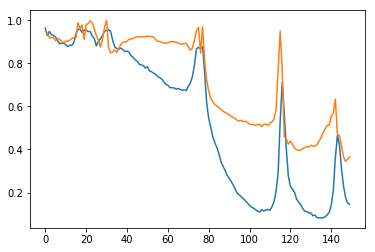

In [31]:
plt.plot(e_tr_t)
plt.plot(e_te_t)
plt.show()

In [29]:
e_tr_t2, e_te_t2 = train_model(model, train_input, train_target_final, test_input, test_target_final, mini_batch_size, 50)

Epoch: 0, Loss: 1.1369333770126109, Training error: 0.14%,, Test error: 0.517%
Epoch: 1, Loss: 1.0869169361889368, Training error: 0.132%,, Test error: 0.516%
Epoch: 2, Loss: 1.057724992744625, Training error: 0.127%,, Test error: 0.515%
Epoch: 3, Loss: 1.023709313198924, Training error: 0.12%,, Test error: 0.512%
Epoch: 4, Loss: 0.9951163975521923, Training error: 0.113%,, Test error: 0.516%
Epoch: 5, Loss: 0.9774471513926984, Training error: 0.11%,, Test error: 0.515%
Epoch: 6, Loss: 0.9853067714720967, Training error: 0.12%,, Test error: 0.507%
Epoch: 7, Loss: 0.9976363896392284, Training error: 0.114%,, Test error: 0.517%
Epoch: 8, Loss: 0.9858318613842126, Training error: 0.11900000000000001%,, Test error: 0.517%
Epoch: 9, Loss: 0.9804338863119485, Training error: 0.12100000000000001%,, Test error: 0.511%
Epoch: 10, Loss: 0.9866344293579461, Training error: 0.11800000000000001%,, Test error: 0.524%
Epoch: 11, Loss: 1.0752486128360028, Training error: 0.134%,, Test error: 0.528%
Ep

In [30]:
e_tr_t += e_tr_t2
e_te_t += e_te_t2